
### Прогноз цены ПЭТФ
Еще один  важный продукт компании СИБУР - полиэтилентерефталат или ПЭТФ, который вы все хорошо знаете по “пластиковым” бутылкам. Крупнейшим потребителем ПЭТФ является Китай, поэтому компании СИБУР важно иметь надежный прогноз котировок ПЭТФ в Китае. Именно их вам предстоит предсказывать в этой задаче.

Данные
Как и в задаче о прогнозировании котировок натурального каучука, вам будут доступны исторические данные котировок смежных продуктов, нефти и курсы валют. Целевой переменной является средняя месячная котировка ПЭТФ в Китае, при этом прогноз должен строиться на основании данных, доступных до 10-го числа предыдущего месяца. Точный набор дат, для которых необходимо построить прогноз, находится в файле pet_test_timestamps.csv.

Крупнейшим потребителем ПЭТФ является Китай, поэтому курс юаня, как и случае с натуральным каучуком, может влиять на долларовую цену ПЭТФ.

Исторический дневной курс (цена открытия, закрытия, максимальная и минимальная) юаня и цены на нефть содержатся в файле pet_daily.csv, а недельные котировки смежных продуктов и продуктов предыдущих переделов на разных рынках - в файле pet_weekly.csv. Целевая переменная для тренировочного периода (с июня 2004 по декабрь 2015) доступна в файле pet_target_train.csv.

Базовое решение
Простой линейный baseline доступен в ноутбуке Baseline - Pet.ipynb. Он воспроизводит тривиальное решение pet_naive_baseline.csv (последнее известное значение тренировочного периода) и создает решение на основе простой линейной модели.

In [1]:
import numpy as np

import pandas as pd

import seaborn as sns

from sklearn import linear_model, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit, \
                                    cross_val_score, GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('pet_daily.csv', header = 0, sep = ',')
data1 = pd.read_csv('pet_weekly.csv', header = 0, sep = ',')
test_target = pd.read_csv('pet_test_timestamps.csv', header = 0, sep = ',')
train_target = pd.read_csv('pet_target_train.csv', header = 0, sep = ',')

In [4]:
data.head(-1)

,date,brent_close,brent_open,brent_max,brent_min,USDCNY_close,USDCNY_open,USDCNY_max,USDCNY_min
0,2002-07-01,25.64,25.50,25.72,25.39,8.2770,8.2770,8.2770,8.2770
1,2002-07-02,25.75,25.61,25.97,25.60,8.2769,8.2769,8.2769,8.2769
2,2002-07-03,25.84,25.73,25.96,25.52,8.2768,8.2768,8.2768,8.2768
3,2002-07-04,25.55,25.88,25.94,25.50,8.2767,8.2767,8.2767,8.2767
4,2002-07-05,25.73,25.65,25.75,25.42,8.2766,8.2766,8.2766,8.2766
...,...,...,...,...,...,...,...,...,...
4215,2019-06-21,65.20,64.86,65.76,64.00,6.8700,6.8524,6.8793,6.8336
4216,2019-06-24,64.86,65.50,65.79,64.08,6.8770,6.8736,6.8873,6.8700
4217,2019-06-25,65.05,64.89,65.98,64.17,6.8798,6.8715,6.8851,6.8655
4218,2019-06-26,66.49,65.80,66.85,65.60,6.8800,6.8876,6.8937,6.8658


In [5]:
data1.head(-1)

,date,paraxylene_CHN_USD,paraxylene_RT_USD,paraxylene_SEA_USD,pta_NEA_USD,ethylene_glycol_EU_EUR,ethylene_glycol_CHN_USD
0,2004-04-30,NaN,669.0,735.0,NaN,622.5,860.0
1,2004-05-07,NaN,680.0,730.0,NaN,650.0,860.0
2,2004-05-14,NaN,664.0,720.0,NaN,650.0,857.5
3,2004-05-21,NaN,657.0,722.5,NaN,650.0,852.5
4,2004-05-28,NaN,667.5,735.0,NaN,650.0,857.5
...,...,...,...,...,...,...,...
793,2019-07-12,885.0,780.0,875.0,766.5,500.0,528.5
794,2019-07-19,853.0,760.0,843.0,748.5,490.0,532.5
795,2019-07-26,848.0,750.0,838.0,714.5,480.0,541.5
796,2019-08-02,819.0,745.0,809.0,701.5,475.0,547.5


In [6]:
data.corr()

,brent_close,brent_open,brent_max,brent_min,USDCNY_close,USDCNY_open,USDCNY_max,USDCNY_min
brent_close,1.000000,0.998912,0.999474,0.999573,-0.623703,-0.623357,-0.624026,-0.623054
brent_open,0.998912,1.000000,0.999537,0.999434,-0.624478,-0.624166,-0.624816,-0.623849
brent_max,0.999474,0.999537,1.000000,0.999313,-0.624896,-0.624566,-0.625216,-0.624262
brent_min,0.999573,0.999434,0.999313,1.000000,-0.623315,-0.622976,-0.623648,-0.622667
USDCNY_close,-0.623703,-0.624478,-0.624896,-0.623315,1.000000,0.999940,0.999964,0.999969
USDCNY_open,-0.623357,-0.624166,-0.624566,-0.622976,0.999940,1.000000,0.999962,0.999965
USDCNY_max,-0.624026,-0.624816,-0.625216,-0.623648,0.999964,0.999962,1.000000,0.999935
USDCNY_min,-0.623054,-0.623849,-0.624262,-0.622667,0.999969,0.999965,0.999935,1.000000


In [7]:
data1.corr()

,paraxylene_CHN_USD,paraxylene_RT_USD,paraxylene_SEA_USD,pta_NEA_USD,ethylene_glycol_EU_EUR,ethylene_glycol_CHN_USD
paraxylene_CHN_USD,1.000000,0.979991,0.999710,0.956538,0.496004,0.677672
paraxylene_RT_USD,0.979991,1.000000,0.981761,0.949881,0.487767,0.641797
paraxylene_SEA_USD,0.999710,0.981761,1.000000,0.950606,0.474244,0.639605
pta_NEA_USD,0.956538,0.949881,0.950606,1.000000,0.285164,0.567304
ethylene_glycol_EU_EUR,0.496004,0.487767,0.474244,0.285164,1.000000,0.804493
ethylene_glycol_CHN_USD,0.677672,0.641797,0.639605,0.567304,0.804493,1.000000


In [8]:
data.columns

Index(['date', 'brent_close', 'brent_open', 'brent_max', 'brent_min',
       'USDCNY_close', 'USDCNY_open', 'USDCNY_max', 'USDCNY_min'],
      dtype='object')

In [9]:
data1.columns

Index(['date', 'paraxylene_CHN_USD', 'paraxylene_RT_USD', 'paraxylene_SEA_USD',
       'pta_NEA_USD', 'ethylene_glycol_EU_EUR', 'ethylene_glycol_CHN_USD'],
      dtype='object')

In [10]:
print(data.shape)

(4221, 9)


In [11]:
print(data1.shape)

(799, 7)


In [12]:
data.isnull().values.any()

False

In [13]:
data1.isnull().values.any()

True

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4221 entries, 0 to 4220
Data columns (total 9 columns):
date            4221 non-null object
brent_close     4221 non-null float64
brent_open      4221 non-null float64
brent_max       4221 non-null float64
brent_min       4221 non-null float64
USDCNY_close    4221 non-null float64
USDCNY_open     4221 non-null float64
USDCNY_max      4221 non-null float64
USDCNY_min      4221 non-null float64
dtypes: float64(8), object(1)
memory usage: 296.9+ KB


In [15]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799 entries, 0 to 798
Data columns (total 7 columns):
date                       799 non-null object
paraxylene_CHN_USD         744 non-null float64
paraxylene_RT_USD          782 non-null float64
paraxylene_SEA_USD         778 non-null float64
pta_NEA_USD                292 non-null float64
ethylene_glycol_EU_EUR     782 non-null float64
ethylene_glycol_CHN_USD    767 non-null float64
dtypes: float64(6), object(1)
memory usage: 43.8+ KB


In [16]:
test_target.head()

,date
0,2016-01-01
1,2016-02-01
2,2016-03-01
3,2016-04-01
4,2016-05-01


In [17]:
test_target.shape

(43, 1)

In [18]:
train_target.head(-1)

,date,pet
0,2004-06-01,961.250
1,2004-07-01,962.000
2,2004-08-01,1053.750
3,2004-09-01,1180.000
4,2004-10-01,1240.000
...,...,...
133,2015-07-01,979.500
134,2015-08-01,908.125
135,2015-09-01,886.250
136,2015-10-01,868.500


In [19]:
train_target.shape

(139, 2)

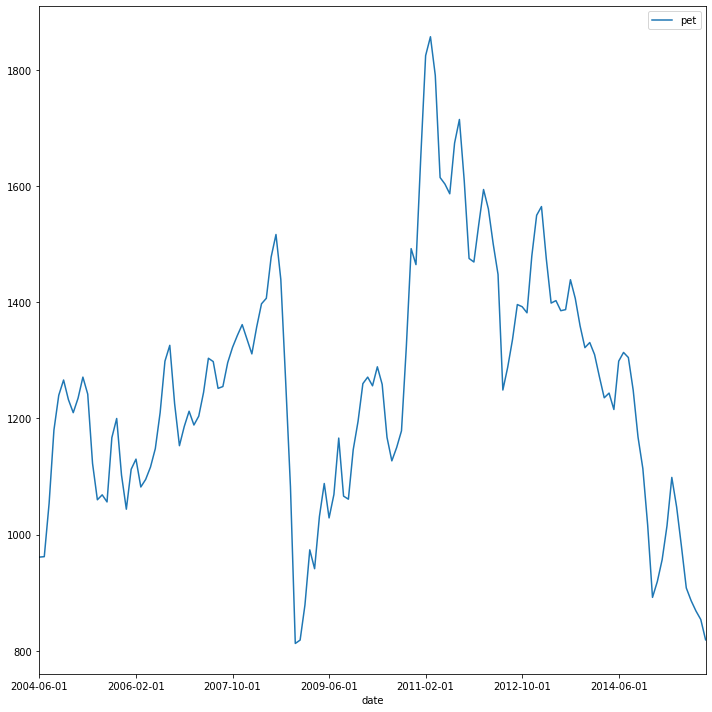

In [20]:
plt.rcParams["figure.figsize"] = (10,10)

train_target.plot('date', 'pet')

# Rotate and align xtick labels
#ax.get_figure().autofmt_xdate()

# make room for tick labels
plt.tight_layout()


plt.show()

## Предобработка данных

In [21]:
NaNList = []
for i in range(0, data1.shape[0]):
    for k in range(0,data1.shape[1]):
        if data1.iloc[[i], [k]].isnull().bool():
              NaNList.append(k)

print(len(NaNList))

649


In [22]:
for i in range(0, data1.shape[1]):
    c=0
    for k in NaNList:
        if i == k:
            c = c + 1
    print ('column number ={0},  amount of NaN = {1} '.format(i, c))

column number =0,  amount of NaN = 0 
column number =1,  amount of NaN = 55 
column number =2,  amount of NaN = 17 
column number =3,  amount of NaN = 21 
column number =4,  amount of NaN = 507 
column number =5,  amount of NaN = 17 
column number =6,  amount of NaN = 32 


In [23]:
data1.drop(data1.columns[[4]], axis=1, inplace=True)

In [24]:
data1.shape

(799, 6)

In [25]:
data1.head()

,date,paraxylene_CHN_USD,paraxylene_RT_USD,paraxylene_SEA_USD,ethylene_glycol_EU_EUR,ethylene_glycol_CHN_USD
0,2004-04-30,NaN,669.0,735.0,622.5,860.0
1,2004-05-07,NaN,680.0,730.0,650.0,860.0
2,2004-05-14,NaN,664.0,720.0,650.0,857.5
3,2004-05-21,NaN,657.0,722.5,650.0,852.5
4,2004-05-28,NaN,667.5,735.0,650.0,857.5


In [26]:
yearList =[]
for i in data['date']:
    yearList.append(int(str(i)[-10:-6]))
    
monthList =[]
for i in data['date']:
    monthList.append(int(str(i)[-5:-3]))

In [27]:
yearList1 =[]
for i in data1['date']:
    yearList1.append(int(str(i)[-10:-6]))
    
monthList1 =[]
for i in data1['date']:
    monthList1.append(int(str(i)[-5:-3]))

In [28]:
data['Year'] = yearList
data['Month'] = monthList

In [29]:
data1['Year'] = yearList1
data1['Month'] = monthList1

In [30]:
data.drop('date', axis=1, inplace=True)
data1.drop('date', axis=1, inplace=True)

In [31]:
data.head(-1)

,brent_close,brent_open,brent_max,brent_min,USDCNY_close,USDCNY_open,USDCNY_max,USDCNY_min,Year,Month
0,25.64,25.50,25.72,25.39,8.2770,8.2770,8.2770,8.2770,2002,7
1,25.75,25.61,25.97,25.60,8.2769,8.2769,8.2769,8.2769,2002,7
2,25.84,25.73,25.96,25.52,8.2768,8.2768,8.2768,8.2768,2002,7
3,25.55,25.88,25.94,25.50,8.2767,8.2767,8.2767,8.2767,2002,7
4,25.73,25.65,25.75,25.42,8.2766,8.2766,8.2766,8.2766,2002,7
...,...,...,...,...,...,...,...,...,...,...
4215,65.20,64.86,65.76,64.00,6.8700,6.8524,6.8793,6.8336,2019,6
4216,64.86,65.50,65.79,64.08,6.8770,6.8736,6.8873,6.8700,2019,6
4217,65.05,64.89,65.98,64.17,6.8798,6.8715,6.8851,6.8655,2019,6
4218,66.49,65.80,66.85,65.60,6.8800,6.8876,6.8937,6.8658,2019,6


In [32]:
data1.head(-1)

,paraxylene_CHN_USD,paraxylene_RT_USD,paraxylene_SEA_USD,ethylene_glycol_EU_EUR,ethylene_glycol_CHN_USD,Year,Month
0,NaN,669.0,735.0,622.5,860.0,2004,4
1,NaN,680.0,730.0,650.0,860.0,2004,5
2,NaN,664.0,720.0,650.0,857.5,2004,5
3,NaN,657.0,722.5,650.0,852.5,2004,5
4,NaN,667.5,735.0,650.0,857.5,2004,5
...,...,...,...,...,...,...,...
793,885.0,780.0,875.0,500.0,528.5,2019,7
794,853.0,760.0,843.0,490.0,532.5,2019,7
795,848.0,750.0,838.0,480.0,541.5,2019,7
796,819.0,745.0,809.0,475.0,547.5,2019,8


In [33]:
data.shape

(4221, 10)

In [34]:
data1.shape

(799, 7)

In [35]:
[i + '_MEAN' for i in data.columns]

['brent_close_MEAN',
 'brent_open_MEAN',
 'brent_max_MEAN',
 'brent_min_MEAN',
 'USDCNY_close_MEAN',
 'USDCNY_open_MEAN',
 'USDCNY_max_MEAN',
 'USDCNY_min_MEAN',
 'Year_MEAN',
 'Month_MEAN']

In [36]:
[i + '_MEAN' for i in data1.columns]

['paraxylene_CHN_USD_MEAN',
 'paraxylene_RT_USD_MEAN',
 'paraxylene_SEA_USD_MEAN',
 'ethylene_glycol_EU_EUR_MEAN',
 'ethylene_glycol_CHN_USD_MEAN',
 'Year_MEAN',
 'Month_MEAN']

In [37]:
train_data = pd.DataFrame({'brent_close_MEAN':[],
 'brent_close_MIN':[],
 'brent_close_MAX':[],
 'brent_close_MEDIAN':[],
 'brent_close_STD':[],
 'brent_open_MEAN':[],
 'brent_open_MIN':[],
 'brent_open_MAX':[],
 'brent_open_MEDIAN':[],
 'brent_open_STD':[],
 'brent_max_MEAN':[],
 'brent_max_MIN':[],
 'brent_max_MAX':[],
 'brent_max_MEDIAN':[],
 'brent_max_STD':[],
 'brent_min_MEAN':[],
 'brent_min_MIN':[],
 'brent_min_MAX':[],
 'brent_min_MEDIAN':[],
 'brent_min_STD':[],
 'USDCNY_close_MEAN':[],
 'USDCNY_close_MIN':[],
 'USDCNY_close_MAX':[],
 'USDCNY_close_MEDIAN':[],
 'USDCNY_close_STD':[],
 'USDCNY_open_MEAN':[],
 'USDCNY_open_MIN':[],
 'USDCNY_open_MAX':[],
 'USDCNY_open_MEDIAN':[],
 'USDCNY_open_STD':[],
 'USDCNY_max_MEAN':[],
 'USDCNY_max_MIN':[],
 'USDCNY_max_MAX':[],
 'USDCNY_max_MEDIAN':[],
 'USDCNY_max_STD':[],
 'USDCNY_min_MEAN':[], 
 'USDCNY_min_MIN':[],
 'USDCNY_min_MAX':[],
 'USDCNY_min_MEDIAN':[],
 'USDCNY_min_STD':[],
 'Year_MEAN':[],
 'Month_MEAN':[]})

In [38]:
train_data1 = pd.DataFrame({'paraxylene_CHN_USD_MEAN':[],
 'paraxylene_CHN_USD_MIN':[],
 'paraxylene_CHN_USD_MAX':[],
 'paraxylene_CHN_USD_MEDIAN':[],
 'paraxylene_CHN_USD_STD':[],
 'paraxylene_RT_USD_MEAN':[],
 'paraxylene_RT_USD_MIN':[],
 'paraxylene_RT_USD_MAX':[],
 'paraxylene_RT_USD_MEDIAN':[],
 'paraxylene_RT_USD_STD':[],
 'paraxylene_SEA_USD_MEAN':[],
 'paraxylene_SEA_USD_MIN':[],
 'paraxylene_SEA_USD_MAX':[],
 'paraxylene_SEA_USD_MEDIAN':[],
 'paraxylene_SEA_USD_STD':[],
 'ethylene_glycol_EU_EUR_MEAN':[],
 'ethylene_glycol_EU_EUR_MIN':[],
 'ethylene_glycol_EU_EUR_MAX':[],
 'ethylene_glycol_EU_EUR_MEDIAN':[],
 'ethylene_glycol_EU_EUR_STD':[],
 'ethylene_glycol_CHN_USD_MEAN':[], 
 'ethylene_glycol_CHN_USD_MIN':[],
 'ethylene_glycol_CHN_USD_MAX':[],
 'ethylene_glycol_CHN_USD_MEDIAN':[],
 'ethylene_glycol_CHN_USD_STD':[],
 'Year_MEAN':[],
 'Month_MEAN':[]})

In [39]:
for m in range(2002, 2020):
    for n in range(1, 13):
        x = [ i for i in (data[(data.Year == m) & (data.Month == n)].mean(axis = 0))]
        y = [ i for i in (data[(data.Year == m) & (data.Month == n)].min(axis = 0))]
        z = [ i for i in (data[(data.Year == m) & (data.Month == n)].max(axis = 0))]
        b = [ i for i in (data[(data.Year == m) & (data.Month == n)].median(axis = 0))]
        h = [ i for i in (data[(data.Year == m) & (data.Month == n)].std(axis = 0))]
        new_line = {'brent_close_MEAN':x[0],
 'brent_close_MIN':y[0],
 'brent_close_MAX':z[0],
 'brent_close_MEDIAN':b[0],
 'brent_close_STD':h[0],
 'brent_open_MEAN':x[1],
 'brent_open_MIN':y[1],
 'brent_open_MAX':z[1],
 'brent_open_MEDIAN':b[1],
 'brent_open_STD':h[1],
 'brent_max_MEAN':x[2],
 'brent_max_MIN':y[2],
 'brent_max_MAX':z[2],
 'brent_max_MEDIAN':b[2],
 'brent_max_STD':h[2],
 'brent_min_MEAN':x[3],
 'brent_min_MIN':y[3],
 'brent_min_MAX':z[3],
 'brent_min_MEDIAN':b[3],
 'brent_min_STD':h[3],
 'USDCNY_close_MEAN':x[4],
 'USDCNY_close_MIN':y[4],
 'USDCNY_close_MAX':z[4],
 'USDCNY_close_MEDIAN':b[4],
 'USDCNY_close_STD':h[4],
 'USDCNY_open_MEAN':x[5],
 'USDCNY_open_MIN':y[5],
 'USDCNY_open_MAX':z[5],
 'USDCNY_open_MEDIAN':b[5],
 'USDCNY_open_STD':h[5],
 'USDCNY_max_MEAN':x[6],
 'USDCNY_max_MIN':y[6],
 'USDCNY_max_MAX':z[6],
 'USDCNY_max_MEDIAN':b[6],
 'USDCNY_max_STD':h[6],
 'USDCNY_min_MEAN':x[7], 
 'USDCNY_min_MIN':y[7],
 'USDCNY_min_MAX':z[7],
 'USDCNY_min_MEDIAN':b[7],
 'USDCNY_min_STD':h[7],
 'Year_MEAN':x[9],
 'Month_MEAN':x[9]}
        train_data = train_data.append(new_line, ignore_index=True)

In [40]:
for m in range(2002, 2020):
    for n in range(1, 13):
        x = [ i for i in (data1[(data1.Year == m) & (data1.Month == n)].mean(axis = 0))]
        y = [ i for i in (data1[(data1.Year == m) & (data1.Month == n)].min(axis = 0))]
        z = [ i for i in (data1[(data1.Year == m) & (data1.Month == n)].max(axis = 0))]
        b = [ i for i in (data1[(data1.Year == m) & (data1.Month == n)].median(axis = 0))]
        h = [ i for i in (data1[(data1.Year == m) & (data1.Month == n)].std(axis = 0))]
        new_line = {'paraxylene_CHN_USD_MEAN':x[0],
 'paraxylene_CHN_USD_MIN':y[0],
 'paraxylene_CHN_USD_MAX':z[0],
 'paraxylene_CHN_USD_MEDIAN':b[0],
 'paraxylene_CHN_USD_STD':h[0],
 'paraxylene_RT_USD_MEAN':x[1],
 'paraxylene_RT_USD_MIN':y[1],
 'paraxylene_RT_USD_MAX':z[1],
 'paraxylene_RT_USD_MEDIAN':b[1],
 'paraxylene_RT_USD_STD':h[1],
 'paraxylene_SEA_USD_MEAN':x[2],
 'paraxylene_SEA_USD_MIN':y[2],
 'paraxylene_SEA_USD_MAX':z[2],
 'paraxylene_SEA_USD_MEDIAN':b[2],
 'paraxylene_SEA_USD_STD':h[2],
 'ethylene_glycol_EU_EUR_MEAN':x[3],
 'ethylene_glycol_EU_EUR_MIN':y[3],
 'ethylene_glycol_EU_EUR_MAX':z[3],
 'ethylene_glycol_EU_EUR_MEDIAN':b[3],
 'ethylene_glycol_EU_EUR_STD':h[3],
 'ethylene_glycol_CHN_USD_MEAN':x[4], 
 'ethylene_glycol_CHN_USD_MIN':y[4],
 'ethylene_glycol_CHN_USD_MAX':z[4],
 'ethylene_glycol_CHN_USD_MEDIAN':b[4],
 'ethylene_glycol_CHN_USD_STD':h[4],
 'Year_MEAN':x[5],
 'Month_MEAN':x[6]}
        train_data1 = train_data1.append(new_line, ignore_index=True)

In [41]:
train_data.shape

(216, 42)

In [42]:
train_data1.shape

(216, 27)

In [43]:
train_data.drop(['Year_MEAN', 'Month_MEAN'], axis=1, inplace=True)

In [44]:
#train_data1

In [45]:
train_data2 = pd.DataFrame()

In [46]:
train_data2 = train_data.join(train_data1)

In [47]:
train_data2

,brent_close_MEAN,brent_close_MIN,brent_close_MAX,brent_close_MEDIAN,brent_close_STD,brent_open_MEAN,brent_open_MIN,brent_open_MAX,brent_open_MEDIAN,brent_open_STD,...,ethylene_glycol_EU_EUR_MAX,ethylene_glycol_EU_EUR_MEDIAN,ethylene_glycol_EU_EUR_STD,ethylene_glycol_CHN_USD_MEAN,ethylene_glycol_CHN_USD_MIN,ethylene_glycol_CHN_USD_MAX,ethylene_glycol_CHN_USD_MEDIAN,ethylene_glycol_CHN_USD_STD,Year_MEAN,Month_MEAN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,475.0,465.0,6.614378,532.0,517.5,547.5,531.0,15.024979,2019.0,8.0
212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
NaNList = []
for i in range(0, train_data2.shape[0]):
    for k in range(0,train_data2.shape[1]):
        if train_data2.iloc[[i], [66]].isnull().bool():
            NaNList.append(i)
            break
train_data2.drop(NaNList, axis=0, inplace=True)
train_data = train_data2.reset_index(drop=True)

In [49]:
train_data

,brent_close_MEAN,brent_close_MIN,brent_close_MAX,brent_close_MEDIAN,brent_close_STD,brent_open_MEAN,brent_open_MIN,brent_open_MAX,brent_open_MEDIAN,brent_open_STD,...,ethylene_glycol_EU_EUR_MAX,ethylene_glycol_EU_EUR_MEDIAN,ethylene_glycol_EU_EUR_STD,ethylene_glycol_CHN_USD_MEAN,ethylene_glycol_CHN_USD_MIN,ethylene_glycol_CHN_USD_MAX,ethylene_glycol_CHN_USD_MEDIAN,ethylene_glycol_CHN_USD_STD,Year_MEAN,Month_MEAN
0,32.976500,30.21,34.48,33.265,1.202542,32.881500,30.69,34.62,33.200,1.156539,...,622.5,622.50,NaN,860.000,860.0,860.0,860.00,NaN,2004.0,4.0
1,37.197895,35.93,38.76,37.080,0.828885,36.990526,35.22,38.30,36.960,0.921632,...,650.0,650.00,0.000000,856.875,852.5,860.0,857.50,3.145764,2004.0,5.0
2,35.446667,33.11,39.08,35.300,1.137987,35.418571,33.31,37.15,35.340,0.933168,...,650.0,647.50,2.886751,853.125,847.5,857.5,853.75,4.269563,2004.0,6.0
3,37.667273,35.92,40.03,37.835,1.113960,37.364091,34.25,39.55,37.350,1.182534,...,670.0,645.00,12.449900,892.000,862.5,935.0,880.00,29.864276,2004.0,7.0
4,41.762500,39.61,44.33,41.425,1.504243,41.787000,39.70,44.50,41.455,1.460692,...,795.0,743.75,56.545520,1072.500,955.0,1180.0,1077.50,98.361578,2004.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,71.628571,69.01,74.57,71.620,1.706565,71.375238,67.58,74.46,71.550,1.851768,...,607.5,601.25,11.250000,598.000,589.5,604.0,599.25,7.222650,2019.0,4.0
181,70.134286,64.49,72.62,70.390,1.904646,70.450952,66.24,72.82,70.480,1.476099,...,577.5,575.00,2.850439,551.600,528.5,584.0,542.00,24.579972,2019.0,5.0
182,63.164737,59.97,66.55,62.290,2.078291,62.934737,59.94,66.51,62.400,2.056992,...,545.0,528.75,14.215602,536.250,529.5,547.0,534.25,7.643080,2019.0,6.0
183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,502.5,495.00,10.282469,536.500,528.5,543.5,537.00,7.164728,2019.0,7.0


In [50]:
NaNList = []
for i in range(0, train_data.shape[0]):
    for k in range(0,train_data.shape[1]):
        if train_data.iloc[[i], [k]].isnull().bool():
              NaNList.append(k)

print(len(NaNList))

129


In [51]:
for i in range(0, train_data.shape[1]):
    c=0
    for k in NaNList:
        if i == k:
            c = c + 1
    print ('column number ={0},  amount of NaN = {1} '.format(i, c))

column number =0,  amount of NaN = 2 
column number =1,  amount of NaN = 2 
column number =2,  amount of NaN = 2 
column number =3,  amount of NaN = 2 
column number =4,  amount of NaN = 2 
column number =5,  amount of NaN = 2 
column number =6,  amount of NaN = 2 
column number =7,  amount of NaN = 2 
column number =8,  amount of NaN = 2 
column number =9,  amount of NaN = 2 
column number =10,  amount of NaN = 2 
column number =11,  amount of NaN = 2 
column number =12,  amount of NaN = 2 
column number =13,  amount of NaN = 2 
column number =14,  amount of NaN = 2 
column number =15,  amount of NaN = 2 
column number =16,  amount of NaN = 2 
column number =17,  amount of NaN = 2 
column number =18,  amount of NaN = 2 
column number =19,  amount of NaN = 2 
column number =20,  amount of NaN = 2 
column number =21,  amount of NaN = 2 
column number =22,  amount of NaN = 2 
column number =23,  amount of NaN = 2 
column number =24,  amount of NaN = 2 
column number =25,  amount of NaN =

In [52]:
train_data.drop([0], axis = 0, inplace = True)
train_data = train_data.reset_index(drop=True)

In [53]:
train_data.head()

,brent_close_MEAN,brent_close_MIN,brent_close_MAX,brent_close_MEDIAN,brent_close_STD,brent_open_MEAN,brent_open_MIN,brent_open_MAX,brent_open_MEDIAN,brent_open_STD,...,ethylene_glycol_EU_EUR_MAX,ethylene_glycol_EU_EUR_MEDIAN,ethylene_glycol_EU_EUR_STD,ethylene_glycol_CHN_USD_MEAN,ethylene_glycol_CHN_USD_MIN,ethylene_glycol_CHN_USD_MAX,ethylene_glycol_CHN_USD_MEDIAN,ethylene_glycol_CHN_USD_STD,Year_MEAN,Month_MEAN
0,37.197895,35.93,38.76,37.080,0.828885,36.990526,35.22,38.30,36.960,0.921632,...,650.0,650.00,0.000000,856.875,852.5,860.0,857.50,3.145764,2004.0,5.0
1,35.446667,33.11,39.08,35.300,1.137987,35.418571,33.31,37.15,35.340,0.933168,...,650.0,647.50,2.886751,853.125,847.5,857.5,853.75,4.269563,2004.0,6.0
2,37.667273,35.92,40.03,37.835,1.113960,37.364091,34.25,39.55,37.350,1.182534,...,670.0,645.00,12.449900,892.000,862.5,935.0,880.00,29.864276,2004.0,7.0
3,41.762500,39.61,44.33,41.425,1.504243,41.787000,39.70,44.50,41.455,1.460692,...,795.0,743.75,56.545520,1072.500,955.0,1180.0,1077.50,98.361578,2004.0,8.0
4,42.855909,40.20,46.45,42.035,2.185641,42.626364,39.90,46.80,41.815,2.209282,...,930.0,927.50,56.715665,1158.750,1130.0,1195.0,1155.00,27.195281,2004.0,9.0


In [54]:
#train_data.to_excel('pre_train_data.xlsx')

In [55]:
train_data_ALL = train_data

In [56]:
train_data.shape

(184, 67)

In [57]:
train_data['pet'] = train_target[['pet']]

In [58]:
train_data

,brent_close_MEAN,brent_close_MIN,brent_close_MAX,brent_close_MEDIAN,brent_close_STD,brent_open_MEAN,brent_open_MIN,brent_open_MAX,brent_open_MEDIAN,brent_open_STD,...,ethylene_glycol_EU_EUR_MEDIAN,ethylene_glycol_EU_EUR_STD,ethylene_glycol_CHN_USD_MEAN,ethylene_glycol_CHN_USD_MIN,ethylene_glycol_CHN_USD_MAX,ethylene_glycol_CHN_USD_MEDIAN,ethylene_glycol_CHN_USD_STD,Year_MEAN,Month_MEAN,pet
0,37.197895,35.93,38.76,37.080,0.828885,36.990526,35.22,38.30,36.960,0.921632,...,650.00,0.000000,856.875,852.5,860.0,857.50,3.145764,2004.0,5.0,961.25
1,35.446667,33.11,39.08,35.300,1.137987,35.418571,33.31,37.15,35.340,0.933168,...,647.50,2.886751,853.125,847.5,857.5,853.75,4.269563,2004.0,6.0,962.00
2,37.667273,35.92,40.03,37.835,1.113960,37.364091,34.25,39.55,37.350,1.182534,...,645.00,12.449900,892.000,862.5,935.0,880.00,29.864276,2004.0,7.0,1053.75
3,41.762500,39.61,44.33,41.425,1.504243,41.787000,39.70,44.50,41.455,1.460692,...,743.75,56.545520,1072.500,955.0,1180.0,1077.50,98.361578,2004.0,8.0,1180.00
4,42.855909,40.20,46.45,42.035,2.185641,42.626364,39.90,46.80,41.815,2.209282,...,927.50,56.715665,1158.750,1130.0,1195.0,1155.00,27.195281,2004.0,9.0,1240.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,71.628571,69.01,74.57,71.620,1.706565,71.375238,67.58,74.46,71.550,1.851768,...,601.25,11.250000,598.000,589.5,604.0,599.25,7.222650,2019.0,4.0,NaN
180,70.134286,64.49,72.62,70.390,1.904646,70.450952,66.24,72.82,70.480,1.476099,...,575.00,2.850439,551.600,528.5,584.0,542.00,24.579972,2019.0,5.0,NaN
181,63.164737,59.97,66.55,62.290,2.078291,62.934737,59.94,66.51,62.400,2.056992,...,528.75,14.215602,536.250,529.5,547.0,534.25,7.643080,2019.0,6.0,NaN
182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,495.00,10.282469,536.500,528.5,543.5,537.00,7.164728,2019.0,7.0,NaN


In [59]:
#train_data.to_excel('pre_train_data.xlsx')

In [60]:
NaNList = []
for i in range(0, train_data.shape[0]):
        if train_data.iloc[[i], [67]].isnull().bool():
            NaNList.append(i)

train_data = train_data.drop(NaNList, axis=0)

In [61]:
NaNList = []
for i in range(0, train_data.shape[0]):
    for k in range(0,train_data.shape[1]):
        if train_data.iloc[[i], [k]].isnull().bool():
            NaNList.append(i)
            break
train_data.drop(NaNList, axis=0, inplace=True)
train_data = train_data.reset_index(drop=True)

In [62]:
train_data

,brent_close_MEAN,brent_close_MIN,brent_close_MAX,brent_close_MEDIAN,brent_close_STD,brent_open_MEAN,brent_open_MIN,brent_open_MAX,brent_open_MEDIAN,brent_open_STD,...,ethylene_glycol_EU_EUR_MEDIAN,ethylene_glycol_EU_EUR_STD,ethylene_glycol_CHN_USD_MEAN,ethylene_glycol_CHN_USD_MIN,ethylene_glycol_CHN_USD_MAX,ethylene_glycol_CHN_USD_MEDIAN,ethylene_glycol_CHN_USD_STD,Year_MEAN,Month_MEAN,pet
0,44.415789,40.51,46.96,44.950,1.790802,44.145263,39.40,46.70,44.500,2.151791,...,732.50,5.000000,1021.250,1005.0,1045.0,1017.50,17.017148,2005.0,1.0,1235.000
1,46.271176,43.04,50.06,45.820,2.224702,46.165294,43.70,50.00,45.480,1.945071,...,733.75,1.443376,1074.375,1060.0,1090.0,1073.75,16.630168,2005.0,2.0,1271.250
2,53.272857,50.11,55.65,53.100,1.447122,53.005238,50.08,55.75,53.090,1.582983,...,745.00,11.547005,1082.500,1075.0,1100.0,1077.50,11.902381,2005.0,3.0,1242.000
3,53.307143,50.48,56.51,53.210,1.800428,53.499048,50.60,56.80,53.300,1.765956,...,730.00,31.424513,912.500,780.0,1000.0,920.00,87.642741,2005.0,4.0,1122.500
4,49.742632,47.88,51.43,50.070,1.259836,49.927368,47.90,51.78,49.960,1.339676,...,615.00,31.721444,696.250,660.0,775.0,675.00,53.131127,2005.0,5.0,1060.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,56.749091,52.21,62.07,56.945,2.715765,57.176818,52.99,63.02,57.110,2.799026,...,895.00,48.746795,859.800,816.5,924.5,856.00,39.975930,2015.0,7.0,908.125
127,48.068421,42.69,54.15,49.030,2.837850,47.972632,42.79,51.55,48.760,2.559451,...,776.25,24.947862,736.625,661.5,788.0,748.50,56.502765,2015.0,8.0,886.250
128,48.578000,46.37,50.68,48.745,1.198607,48.793000,46.65,52.92,48.420,1.435190,...,713.75,5.951190,698.375,683.5,712.5,698.75,12.899451,2015.0,9.0,868.500
129,49.292727,46.81,53.05,48.925,1.662973,49.393182,46.91,53.35,48.920,1.737684,...,712.50,18.791620,659.200,633.0,682.5,653.50,19.357169,2015.0,10.0,853.750


Посмотрим теперь на корреляцию Пирсона.

In [63]:
train_data.drop(labels='pet', axis=1).corrwith(train_data.pet)

brent_close_MEAN                  0.767608
brent_close_MIN                   0.776909
brent_close_MAX                   0.746888
brent_close_MEDIAN                0.768576
brent_close_STD                  -0.000689
                                    ...   
ethylene_glycol_CHN_USD_MAX       0.742719
ethylene_glycol_CHN_USD_MEDIAN    0.772559
ethylene_glycol_CHN_USD_STD      -0.085155
Year_MEAN                         0.066246
Month_MEAN                       -0.108955
Length: 67, dtype: float64

In [64]:
#train_data.drop(labels='pet', axis=1).corrwith(train_data.pet).to_excel('cor_train_data.xlsx')

In [65]:
train_data.corr()

,brent_close_MEAN,brent_close_MIN,brent_close_MAX,brent_close_MEDIAN,brent_close_STD,brent_open_MEAN,brent_open_MIN,brent_open_MAX,brent_open_MEDIAN,brent_open_STD,...,ethylene_glycol_EU_EUR_MEDIAN,ethylene_glycol_EU_EUR_STD,ethylene_glycol_CHN_USD_MEAN,ethylene_glycol_CHN_USD_MIN,ethylene_glycol_CHN_USD_MAX,ethylene_glycol_CHN_USD_MEDIAN,ethylene_glycol_CHN_USD_STD,Year_MEAN,Month_MEAN,pet
brent_close_MEAN,1.000000,0.995615,0.995252,0.999707,0.203281,0.999901,0.995643,0.992995,0.999704,0.200922,...,0.574071,-0.072879,0.650946,0.657175,0.637085,0.649187,0.006279,0.389605,0.006945,0.767608
brent_close_MIN,0.995615,1.000000,0.984058,0.995071,0.119497,0.995185,0.999423,0.980631,0.994574,0.117695,...,0.579037,-0.097135,0.656609,0.667803,0.637815,0.655390,-0.030818,0.396280,0.004154,0.776909
brent_close_MAX,0.995252,0.984058,1.000000,0.994124,0.289533,0.995811,0.984810,0.998983,0.994957,0.286955,...,0.566628,-0.042045,0.634799,0.635701,0.626856,0.631736,0.047234,0.383053,0.015104,0.746888
brent_close_MEDIAN,0.999707,0.995071,0.994124,1.000000,0.200406,0.999505,0.995111,0.991660,0.999843,0.197258,...,0.574510,-0.073695,0.653022,0.659463,0.638707,0.651607,0.004109,0.388232,0.005026,0.768576
brent_close_STD,0.203281,0.119497,0.289533,0.200406,1.000000,0.208711,0.125951,0.302626,0.207643,0.984179,...,0.047509,0.306108,0.027182,-0.029307,0.086297,0.015368,0.445404,-0.001449,0.062209,-0.000689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ethylene_glycol_CHN_USD_MEDIAN,0.649187,0.655390,0.631736,0.651607,0.015368,0.646038,0.656425,0.624096,0.647658,-0.017684,...,0.830104,-0.025213,0.999032,0.991173,0.986781,1.000000,0.103915,0.079824,-0.018915,0.772559
ethylene_glycol_CHN_USD_STD,0.006279,-0.030818,0.047234,0.004109,0.445404,0.010810,-0.025136,0.056626,0.008879,0.438260,...,0.139682,0.389615,0.120899,-0.009854,0.249098,0.103915,1.000000,-0.075036,0.079819,-0.085155
Year_MEAN,0.389605,0.396280,0.383053,0.388232,-0.001449,0.391012,0.400146,0.378713,0.389465,-0.011449,...,0.340522,-0.022926,0.076506,0.086311,0.066898,0.079824,-0.075036,1.000000,-0.019607,0.066246
Month_MEAN,0.006945,0.004154,0.015104,0.005026,0.062209,0.010321,0.005758,0.019010,0.008266,0.065805,...,0.077798,0.116129,-0.021575,-0.037932,-0.015477,-0.018915,0.079819,-0.019607,1.000000,-0.108955


In [66]:
#sns.pairplot(train_data)

Есть немного мультиколлинеарности? 
Выбросы?
может что-нибудь выкинуть?

In [67]:
train_data.drop(['brent_close_STD','brent_open_STD','brent_max_STD','brent_min_STD', 'USDCNY_close_MEAN', 'USDCNY_close_MIN', 'USDCNY_close_MAX',
       'USDCNY_close_MEDIAN', 'USDCNY_close_STD', 'USDCNY_open_MEAN',
       'USDCNY_open_MIN', 'USDCNY_open_MAX', 'USDCNY_open_MEDIAN',
       'USDCNY_open_STD', 'USDCNY_max_MEAN', 'USDCNY_max_MIN',
       'USDCNY_max_MAX', 'USDCNY_max_MEDIAN', 'USDCNY_max_STD',
       'USDCNY_min_MEAN', 'USDCNY_min_MIN', 'USDCNY_min_MAX',
       'USDCNY_min_MEDIAN', 'USDCNY_min_STD', 'paraxylene_CHN_USD_STD', 'paraxylene_RT_USD_STD', 'ethylene_glycol_CHN_USD_MIN', 'ethylene_glycol_CHN_USD_MAX',
       'ethylene_glycol_CHN_USD_MEDIAN', 'ethylene_glycol_CHN_USD_STD', 'paraxylene_SEA_USD_STD', 'Year_MEAN', 'Month_MEAN'], axis=1, inplace=True)

In [68]:
#train_data.columns

In [69]:
train_data.mean()

brent_close_MEAN                   83.924379
brent_close_MIN                    79.779695
brent_close_MAX                    88.187252
brent_close_MEDIAN                 83.882328
brent_open_MEAN                    83.926630
brent_open_MIN                     79.665954
brent_open_MAX                     88.397634
brent_open_MEDIAN                  83.903855
brent_max_MEAN                     85.002827
brent_max_MIN                      81.015954
brent_max_MAX                      89.246565
brent_max_MEDIAN                   84.924275
brent_min_MEAN                     82.794787
brent_min_MIN                      78.776489
brent_min_MAX                      87.040534
brent_min_MEDIAN                   82.800687
paraxylene_CHN_USD_MEAN          1192.643448
paraxylene_CHN_USD_MIN           1152.606870
paraxylene_CHN_USD_MAX           1232.645038
paraxylene_CHN_USD_MEDIAN        1192.654580
paraxylene_RT_USD_MEAN           1130.971660
paraxylene_RT_USD_MIN            1092.164122
paraxylene

Нужно масштабировать...

In [70]:
X = train_data.drop('pet',1)
y = train_data['pet']

In [71]:
scaler = StandardScaler()
scaler.fit(X, y)
X_scaled = scaler.transform(X)

In [72]:
X_scaled

array([[-1.60831043, -1.64260549, -1.65658457, ..., -0.11491134,
        -0.91993983,  0.41728093],
       [-1.53278158, -1.53677854, -1.53202104, ..., -0.10636993,
        -1.14378634,  0.67397578],
       [-1.24775809, -1.24104869, -1.30740486, ..., -0.02949721,
        -0.50788497,  0.71323499],
       ...,
       [-1.43887571, -1.39748853, -1.50710833, ..., -0.24303253,
        -0.86007389, -1.14281976],
       [-1.40978069, -1.37908384, -1.4118775 , ..., -0.25157394,
        -0.05192402, -1.33210956],
       [-1.54964182, -1.51460926, -1.51273378, ...,  0.17549669,
        -0.29494155, -1.63265393]])

## Кросс валидация

какую стратегию кросс валидации выбрать?

Обучение / тест

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

Стратегии кросс-валидации

In [74]:
cv_strategy_KFold = KFold(n_splits=5, random_state=None, shuffle=False)
cv_strategy_TMS = TimeSeriesSplit(max_train_size=None, n_splits=5)

Загружаем метрику качества

In [75]:
scorer = metrics.make_scorer(metrics.mean_absolute_error)
scorerCV = metrics.make_scorer(metrics.mean_absolute_error, greater_is_better=False)

### linear_regressor

In [76]:
linear_regressor = linear_model.LinearRegression()
linear_regressor.fit(X_train, y_train)
predictions = linear_regressor.predict(X_test)

In [77]:
#print (len(y_train))
#print (len(y_test))

In [78]:
print (predictions)

[1459.77790094 1420.92562748 1460.24785882 1423.43000917 1402.05169255
 1384.77470699 1376.52431957 1328.9059952  1296.58229135 1351.96913098
 1378.7391834  1413.33273029 1289.47319743 1228.41369477 1199.39933035
 1055.90529129 1015.67802456 1120.24476961 1046.70541237 1154.24208555
 1288.23516783 1220.27813963 1035.41463084 1093.7886968  1047.71924609
 1018.48020441 1009.00994798]


In [79]:
y_test

104    1359.375000
105    1322.000000
106    1330.833333
107    1310.000000
108    1271.875000
109    1235.625000
110    1243.750000
111    1215.500000
112    1298.750000
113    1313.750000
114    1305.000000
115    1248.750000
116    1168.000000
117    1113.750000
118    1016.250000
119     891.875000
120     919.166667
121     956.875000
122    1015.000000
123    1098.500000
124    1047.500000
125     979.500000
126     908.125000
127     886.250000
128     868.500000
129     853.750000
130     818.750000
Name: pet, dtype: float64

In [80]:
metrics.mean_absolute_error(y_test, predictions)

130.65128531652076

In [81]:
linear_regressor.coef_

array([  3417.3247193 ,    532.79179271,   -214.6442532 ,   -392.7793718 ,
          -79.62296112,    -30.76786008,   -687.10790345,    798.34295067,
        -1957.06990044,    106.36578846,    996.49431711,   -503.28886049,
          220.17801679,   -881.04159074,   -532.32715732,   -771.12069511,
        13801.00277958,  -3110.89135567,  -3347.65327653,  -6187.79443478,
         -456.16618391,    132.99822297,    245.39968771,    122.97442429,
       -13896.91851342,   2938.03956263,   3213.41573365,   6643.35913399,
         -354.87083433,    308.73211762,     24.54454733,     29.05216656,
           24.4324096 ,     69.38503574])

In [82]:
linear_regressor.intercept_

1287.0839640172146

In [83]:
lr_scoring = cross_val_score(linear_regressor, X_train, y_train, scoring = scorer, cv = cv_strategy_KFold)
print ('LR (KFold)) mean:{}, max:{}, min:{}, std:{}'.format(lr_scoring .mean(), lr_scoring .max(), 
                                                     lr_scoring .min(), lr_scoring .std()))

LR (KFold)) mean:103.1792450292691, max:163.3252180620271, min:66.89067331454359, std:33.39718048485181


In [84]:
lr_scoring

array([ 66.89067331, 111.28360757,  81.45371577, 163.32521806,
        92.94301043])

In [85]:
lr_scoring = cross_val_score(linear_regressor, X_train, y_train, scoring = scorer, cv = cv_strategy_TMS)
print ('LR (TMS)) mean:{}, max:{}, min:{}, std:{}'.format(lr_scoring .mean(), lr_scoring .max(), 
                                                     lr_scoring .min(), lr_scoring .std()))

LR (TMS)) mean:176.19667497051643, max:332.02110193940473, min:82.1752637148193, std:91.08459346038957


In [86]:
lr_scoring

array([139.24098931, 332.02110194,  82.17526371, 221.59307742,
       105.95294247])

In [87]:
linear_regressor.get_params().keys()

dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'normalize'])

### lasso_regressor

In [88]:
lasso_regressor = linear_model.Lasso()
lasso_regressor.fit(X_train, y_train)
predictions = lasso_regressor.predict(X_test)

In [89]:
metrics.mean_absolute_error(y_test, predictions)

112.55583971097214

In [90]:
ls_scoring = cross_val_score(lasso_regressor, X_train, y_train, scoring = scorer, cv = cv_strategy_KFold)
print ('LR (KFold)) mean:{}, max:{}, min:{}, std:{}'.format(ls_scoring .mean(), ls_scoring .max(), 
                                                     ls_scoring .min(), ls_scoring .std()))

LR (KFold)) mean:94.54141936461424, max:156.81214875051376, min:56.22990596038595, std:35.40799089501361


In [91]:
ls_scoring

array([ 56.22990596,  79.55253315,  71.91358129, 156.81214875,
       108.19892766])

In [92]:
ls_scoring = cross_val_score(lasso_regressor, X_train, y_train, scoring = scorer, cv = cv_strategy_TMS)
print ('LR (TMS)) mean:{}, max:{}, min:{}, std:{}'.format(ls_scoring .mean(), ls_scoring .max(), 
                                                     ls_scoring .min(), ls_scoring .std()))

LR (TMS)) mean:94.03047681562029, max:160.13338619385746, min:41.21733685220826, std:38.97771433532373


In [93]:
ls_scoring

array([ 41.21733685,  80.62901634,  82.73107439, 160.13338619,
       105.44157031])

In [94]:
lasso_regressor.get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'positive', 'precompute', 'random_state', 'selection', 'tol', 'warm_start'])

In [95]:
parameters_grid = {
    'alpha' : [0.5, 1, 1.5, 2],
    'tol' : [0.00001, 0.0001, 0.001],
    'max_iter': [500, 1000, 2000],
}

In [96]:
grid_cv = GridSearchCV(lasso_regressor, parameters_grid, scoring = scorerCV, cv = cv_strategy_KFold)

In [97]:
%%time
grid_cv.fit(X_train, y_train)

CPU times: user 586 ms, sys: 2.97 ms, total: 589 ms
Wall time: 589 ms


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.5, 1, 1.5, 2],
                         'max_iter': [500, 1000, 2000],
                         'tol': [1e-05, 0.0001, 0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=0)

In [98]:
grid_cv.best_estimator_

Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=2000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.001, warm_start=False)

In [99]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-91.09595518757138
{'alpha': 0.5, 'max_iter': 2000, 'tol': 0.001}


In [100]:
predictions = grid_cv.predict(X_test)
metrics.mean_absolute_error(y_test, predictions)

104.3832500970394

In [101]:
grid_cv = GridSearchCV(lasso_regressor, parameters_grid, scoring = scorerCV, cv = cv_strategy_TMS)

In [102]:
%%time
grid_cv.fit(X_train, y_train)

CPU times: user 468 ms, sys: 2.29 ms, total: 470 ms
Wall time: 470 ms


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.5, 1, 1.5, 2],
                         'max_iter': [500, 1000, 2000],
                         'tol': [1e-05, 0.0001, 0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=0)

In [103]:
grid_cv.best_estimator_

Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=500, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [104]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-92.19833260974293
{'alpha': 0.5, 'max_iter': 500, 'tol': 0.0001}


In [105]:
predictions = grid_cv.predict(X_test)
metrics.mean_absolute_error(y_test, predictions)

103.4062828784122

### Ridge regressor

In [106]:
ridge_regressor = linear_model.Ridge()
ridge_regressor.fit(X_train, y_train)
predictions = ridge_regressor.predict(X_test)

In [107]:
metrics.mean_absolute_error(y_test, predictions)

103.04063974255652

In [108]:
rd_scoring = cross_val_score(ridge_regressor, X_train, y_train, scoring = scorer, cv = cv_strategy_KFold)
print ('LR (KFold)) mean:{}, max:{}, min:{}, std:{}'.format(rd_scoring .mean(), rd_scoring .max(), 
                                                     rd_scoring .min(), rd_scoring .std()))

LR (KFold)) mean:91.67042031185457, max:160.50504134381148, min:56.07974951977009, std:37.2906410655964


In [109]:
rd_scoring

array([ 56.07974952,  71.25646525,  70.27168644, 160.50504134,
       100.23915901])

In [110]:
rd_scoring = cross_val_score(ridge_regressor, X_train, y_train, scoring = scorer, cv = cv_strategy_TMS)
print ('LR (KFold)) mean:{}, max:{}, min:{}, std:{}'.format(rd_scoring .mean(), rd_scoring .max(), 
                                                     rd_scoring .min(), rd_scoring .std()))

LR (KFold)) mean:94.59796191387882, max:159.59634367426048, min:54.30127566538534, std:35.818312107657455


In [111]:
rd_scoring

array([ 54.30127567,  83.70175047,  74.42642683, 159.59634367,
       100.96401293])

In [112]:
ridge_regressor.get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'random_state', 'solver', 'tol'])

In [113]:
parameters_grid = {
    'alpha' : [0.5, 1, 1.5, 2],
    'tol' : [0.00001, 0.0001, 0.001],
    'max_iter': [500, 1000, 2000],
}

In [114]:
grid_cv = GridSearchCV(ridge_regressor, parameters_grid, scoring = scorerCV, cv = cv_strategy_KFold)

In [115]:
%%time
grid_cv.fit(X_train, y_train)

CPU times: user 923 ms, sys: 71.8 ms, total: 995 ms
Wall time: 300 ms


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.5, 1, 1.5, 2],
                         'max_iter': [500, 1000, 2000],
                         'tol': [1e-05, 0.0001, 0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=0)

In [116]:
grid_cv.best_estimator_

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=500, normalize=False,
      random_state=None, solver='auto', tol=1e-05)

In [117]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-90.4476601304479
{'alpha': 0.5, 'max_iter': 500, 'tol': 1e-05}


In [118]:
predictions = grid_cv.predict(X_test)
metrics.mean_absolute_error(y_test, predictions)

100.4759546427352

In [119]:
grid_cv = GridSearchCV(ridge_regressor, parameters_grid, scoring = scorerCV, cv = cv_strategy_TMS)

In [120]:
%%time
grid_cv.fit(X_train, y_train)

CPU times: user 850 ms, sys: 87.5 ms, total: 938 ms
Wall time: 309 ms


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.5, 1, 1.5, 2],
                         'max_iter': [500, 1000, 2000],
                         'tol': [1e-05, 0.0001, 0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=0)

In [121]:
grid_cv.best_estimator_

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=500, normalize=False,
      random_state=None, solver='auto', tol=1e-05)

In [122]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-93.39619601127787
{'alpha': 0.5, 'max_iter': 500, 'tol': 1e-05}


In [123]:
predictions = grid_cv.predict(X_test)
metrics.mean_absolute_error(y_test, predictions)

100.4759546427352

### SGDRegressor

In [466]:
#SGD_regressor = linear_model.SGDRegressor(shuffle=False, tol=4)
SGD_regressor = linear_model.SGDRegressor(shuffle=False,tol=4, power_t=0.5, penalty= 'l2',\
                                          eta0= 0.01, alpha= 0.05)
SGD_regressor.fit(X_train, y_train)
predictions = SGD_regressor.predict(X_test)

In [467]:
metrics.mean_absolute_error(y_test, predictions)

56.12414160848579

In [468]:
SGD_scoring = cross_val_score(SGD_regressor, X_train, y_train, scoring = scorer, cv = cv_strategy_KFold)
print ('SGD (KFold) mean:{}, max:{}, min:{}, std:{}'.format(SGD_scoring .mean(), SGD_scoring .max(), 
                                                     SGD_scoring .min(), SGD_scoring .std()))

SGD (KFold) mean:91.39847194455123, max:188.6092233341332, min:52.69923455168907, std:50.052364179301115


In [469]:
SGD_scoring

array([ 54.92034061,  52.69923455,  82.00128638, 188.60922333,
        78.76227484])

In [470]:
SGD_scoring = cross_val_score(SGD_regressor, X_train, y_train, scoring = scorer, cv = cv_strategy_TMS)
print ('SGD (TMS) mean:{}, max:{}, min:{}, std:{}'.format(SGD_scoring .mean(), SGD_scoring .max(), 
                                                     SGD_scoring .min(), SGD_scoring .std()))

SGD (TMS) mean:421.8232397997672, max:843.3680217683911, min:56.2773543705801, std:312.38542412248626


In [471]:
SGD_scoring

array([737.11356848, 843.36802177, 171.8994209 , 300.45783348,
        56.27735437])

In [404]:
SGD_regressor.get_params().keys()

dict_keys(['alpha', 'average', 'early_stopping', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter_no_change', 'penalty', 'power_t', 'random_state', 'shuffle', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [405]:
parameters_grid = {
    'penalty' : ['l1', 'l2'],
    'alpha' : [0.0001, 0.001, 0.005],
    'eta0' : [0.001, 0.01, 0.05],
    #'tol' : [3.5, 4, 4.5],
    'power_t' : [0.3, 0.5, 0.7], 
    
}

In [406]:
#grid_cv = GridSearchCV(SGD_regressor, parameters_grid, scoring = scorerCV, cv = cv_strategy_KFold)

In [407]:
#%%time
#grid_cv.fit(X_train, y_train)

In [408]:
#grid_cv.best_estimator_

In [409]:
#print(grid_cv.best_score_)
#print(grid_cv.best_params_)

In [410]:
#predictions = grid_cv.predict(X_test)
#metrics.mean_absolute_error(y_test, predictions)

In [411]:
#grid_cv = GridSearchCV(SGD_regressor, parameters_grid, scoring = scorerCV, cv = cv_strategy_TMS)

In [412]:
#%%time
#grid_cv.fit(X_train, y_train)

In [413]:
#grid_cv.best_estimator_

In [414]:
#print(grid_cv.best_score_)
#print(grid_cv.best_params_)

In [415]:
#predictions = grid_cv.predict(X_test)
#metrics.mean_absolute_error(y_test, predictions)

In [416]:
randomized_grid_cv = RandomizedSearchCV(SGD_regressor, parameters_grid, scoring = scorerCV, \
                                        cv = cv_strategy_KFold, n_iter = 100)

In [417]:
%%time
randomized_grid_cv.fit(X_train, y_train)

CPU times: user 3.05 s, sys: 5.13 ms, total: 3.05 s
Wall time: 3.06 s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   error_score='raise-deprecating',
                   estimator=SGDRegressor(alpha=0.001, average=False,
                                          early_stopping=False, epsilon=0.1,
                                          eta0=0.01, fit_intercept=True,
                                          l1_ratio=0.15,
                                          learning_rate='invscaling',
                                          loss='squared_loss', max_iter=1000,
                                          n_iter_no_change=5, penalty='l2',
                                          power_t=0.5, random_state=Non...
                                          validation_fraction=0.1, verbose=0,
                                          warm_start=False),
                   iid='warn', n_iter=100, n_jobs=None,
                   param_distributions={'alpha': [0.0001, 0.001, 0.005],
                             

In [418]:
randomized_grid_cv.best_estimator_

SGDRegressor(alpha=0.005, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.3, random_state=None,
             shuffle=False, tol=4, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [419]:
print(randomized_grid_cv.best_score_)
print(randomized_grid_cv.best_params_)

-80.12173314691441
{'power_t': 0.3, 'penalty': 'l2', 'eta0': 0.01, 'alpha': 0.005}


In [420]:
predictions = randomized_grid_cv.predict(X_test)
metrics.mean_absolute_error(y_test, predictions)

75.8061370654723

In [421]:
randomized_grid_cv = RandomizedSearchCV(SGD_regressor, parameters_grid, scoring = scorerCV, \
                                        cv = cv_strategy_TMS, n_iter = 100)

In [422]:
%%time
randomized_grid_cv.fit(X_train, y_train)

CPU times: user 2.33 s, sys: 4.46 ms, total: 2.34 s
Wall time: 2.34 s


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
                   error_score='raise-deprecating',
                   estimator=SGDRegressor(alpha=0.001, average=False,
                                          early_stopping=False, epsilon=0.1,
                                          eta0=0.01, fit_intercept=True,
                                          l1_ratio=0.15,
                                          learning_rate='invscaling',
                                          loss='squared_loss', max_iter=1000,
                                          n_iter_no_change=5, penalty='l2',
                                          power_t=0.5, random_state=None,...
                                          validation_fraction=0.1, verbose=0,
                                          warm_start=False),
                   iid='warn', n_iter=100, n_jobs=None,
                   param_distributions={'alpha': [0.0001, 0.001, 0.005],
                              

In [423]:
randomized_grid_cv.best_estimator_

SGDRegressor(alpha=0.005, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.05, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.3, random_state=None,
             shuffle=False, tol=4, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [424]:
print(randomized_grid_cv.best_score_)
print(randomized_grid_cv.best_params_)

-175.24035951560617
{'power_t': 0.3, 'penalty': 'l2', 'eta0': 0.05, 'alpha': 0.005}


In [425]:
predictions = randomized_grid_cv.predict(X_test)
metrics.mean_absolute_error(y_test, predictions)

97.78042765743255

### GradientBoostingRegressor

In [162]:
estimator = GradientBoostingRegressor()
estimator.fit(X_train, y_train)
predictions = estimator.predict(X_test)

In [163]:
metrics.mean_absolute_error(y_test, predictions)

142.86960267167345

In [164]:
GBR_scoring = cross_val_score(estimator, X_train, y_train, scoring = scorer, cv = cv_strategy_KFold)
print ('GBR (KFold) mean:{}, max:{}, min:{}, std:{}'.format(GBR_scoring .mean(), GBR_scoring .max(), 
                                                     GBR_scoring .min(), GBR_scoring .std()))

GBR (KFold) mean:106.78131945192067, max:178.21993412230412, min:63.414619346176735, std:41.176544003429996


In [165]:
GBR_scoring

array([ 63.41461935,  72.72155238,  97.21742714, 178.21993412,
       122.33306427])

In [166]:
GBR_scoring = cross_val_score(estimator, X_train, y_train, scoring = scorer, cv = cv_strategy_TMS)
print ('GBR (TMS) mean:{}, max:{}, min:{}, std:{}'.format(GBR_scoring .mean(), GBR_scoring .max(), 
                                                     GBR_scoring .min(), GBR_scoring .std()))

GBR (TMS) mean:116.30564892486814, max:211.70674658638416, min:44.67488971505162, std:57.98544445080194


In [167]:
GBR_scoring

array([ 44.67488972, 111.51434438,  72.34755732, 211.70674659,
       141.28470663])

In [168]:
estimator.get_params().keys()

dict_keys(['alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'presort', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [169]:
parameters_grid = {
    'n_estimators' : [50, 100, 200, 500],
    'max_depth' : [3, 5, 10, 15],
    
}

In [170]:
grid_cv = GridSearchCV(estimator, parameters_grid, scoring = scorerCV, cv = cv_strategy_KFold)

In [171]:
%%time
grid_cv.fit(X_train, y_train)

CPU times: user 8.75 s, sys: 27.8 ms, total: 8.78 s
Wall time: 8.82 s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_...
                                                 n_iter_no_change=None,
                                          

In [172]:
grid_cv.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [173]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-98.13596422134881
{'max_depth': 5, 'n_estimators': 100}


In [174]:
predictions = grid_cv.predict(X_test)
metrics.mean_absolute_error(y_test, predictions)

131.60549825251223

In [175]:
grid_cv = GridSearchCV(estimator, parameters_grid, scoring = scorerCV, cv = cv_strategy_TMS)

In [176]:
%%time
grid_cv.fit(X_train, y_train)

CPU times: user 6.52 s, sys: 14.6 ms, total: 6.53 s
Wall time: 6.54 s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_we...
                                                 n_iter_no_change=None,
                                           

In [177]:
grid_cv.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=10,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [178]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-109.9528895956136
{'max_depth': 10, 'n_estimators': 500}


In [179]:
predictions = grid_cv.predict(X_test)
metrics.mean_absolute_error(y_test, predictions)

137.8363285080032

In [180]:
#randomized_grid_cv = RandomizedSearchCV(estimator, parameters_grid, scoring = scorerCV, cv = cv_strategy_KFold, n_iter = 20, random_state = 0)

In [181]:
#%%time
#randomized_grid_cv.fit(X_train, y_train)

In [182]:
#print(randomized_grid_cv.best_score_)
#print(randomized_grid_cv.best_params_)

In [183]:
#predictions = randomized_grid_cv.predict(X_test)
#metrics.mean_absolute_error(y_test, predictions)

In [184]:
#randomized_grid_cv = RandomizedSearchCV(estimator, parameters_grid, scoring = scorerCV, cv = cv_strategy_TMS, n_iter = 20, random_state = 0)

In [185]:
#%%time
#randomized_grid_cv.fit(X_train, y_train)

In [186]:
#print(randomized_grid_cv.best_score_)
#print(randomized_grid_cv.best_params_)

In [187]:
#predictions = randomized_grid_cv.predict(X_test)
#metrics.mean_absolute_error(y_test, predictions)

In [188]:
train_data_ALL.drop(['brent_close_STD','brent_open_STD','brent_max_STD','brent_min_STD', 'USDCNY_close_MEAN', 'USDCNY_close_MIN', 'USDCNY_close_MAX',
       'USDCNY_close_MEDIAN', 'USDCNY_close_STD', 'USDCNY_open_MEAN',
       'USDCNY_open_MIN', 'USDCNY_open_MAX', 'USDCNY_open_MEDIAN',
       'USDCNY_open_STD', 'USDCNY_max_MEAN', 'USDCNY_max_MIN',
       'USDCNY_max_MAX', 'USDCNY_max_MEDIAN', 'USDCNY_max_STD',
       'USDCNY_min_MEAN', 'USDCNY_min_MIN', 'USDCNY_min_MAX',
       'USDCNY_min_MEDIAN', 'USDCNY_min_STD', 'paraxylene_CHN_USD_STD', 'paraxylene_RT_USD_STD', 'ethylene_glycol_CHN_USD_MIN', 'ethylene_glycol_CHN_USD_MAX',
       'ethylene_glycol_CHN_USD_MEDIAN', 'ethylene_glycol_CHN_USD_STD', 'paraxylene_SEA_USD_STD'], axis=1, inplace=True)

In [189]:
train_data_ALL

,brent_close_MEAN,brent_close_MIN,brent_close_MAX,brent_close_MEDIAN,brent_open_MEAN,brent_open_MIN,brent_open_MAX,brent_open_MEDIAN,brent_max_MEAN,brent_max_MIN,...,paraxylene_SEA_USD_MEDIAN,ethylene_glycol_EU_EUR_MEAN,ethylene_glycol_EU_EUR_MIN,ethylene_glycol_EU_EUR_MAX,ethylene_glycol_EU_EUR_MEDIAN,ethylene_glycol_EU_EUR_STD,ethylene_glycol_CHN_USD_MEAN,Year_MEAN,Month_MEAN,pet
0,37.197895,35.93,38.76,37.080,36.990526,35.22,38.30,36.960,37.634737,36.00,...,726.25,650.000,650.0,650.0,650.00,0.000000,856.875,2004.0,5.0,961.25
1,35.446667,33.11,39.08,35.300,35.418571,33.31,37.15,35.340,35.976190,33.88,...,735.00,647.500,645.0,650.0,647.50,2.886751,853.125,2004.0,6.0,962.00
2,37.667273,35.92,40.03,37.835,37.364091,34.25,39.55,37.350,38.024091,36.35,...,772.50,648.500,640.0,670.0,645.00,12.449900,892.000,2004.0,7.0,1053.75
3,41.762500,39.61,44.33,41.425,41.787000,39.70,44.50,41.455,42.324500,39.95,...,898.75,738.125,670.0,795.0,743.75,56.545520,1072.500,2004.0,8.0,1180.00
4,42.855909,40.20,46.45,42.035,42.626364,39.90,46.80,41.815,43.370455,40.90,...,917.50,900.000,815.0,930.0,927.50,56.715665,1158.750,2004.0,9.0,1240.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,71.628571,69.01,74.57,71.620,71.375238,67.58,74.46,71.550,72.131429,69.22,...,995.50,598.125,582.5,607.5,601.25,11.250000,598.000,2019.0,4.0,NaN
180,70.134286,64.49,72.62,70.390,70.450952,66.24,72.82,70.480,71.167619,66.28,...,867.00,574.000,570.0,577.5,575.00,2.850439,551.600,2019.0,5.0,NaN
181,63.164737,59.97,66.55,62.290,62.934737,59.94,66.51,62.400,63.980526,61.85,...,832.00,528.750,512.5,545.0,528.75,14.215602,536.250,2019.0,6.0,NaN
182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,840.50,493.125,480.0,502.5,495.00,10.282469,536.500,2019.0,7.0,NaN


In [769]:
#stop

In [472]:
linear_regressor = linear_model.Ridge(alpha = 0.5)
linear_regressor.fit(X_train, y_train)

SGD_regressor = linear_model.SGDRegressor(shuffle=False,tol=4, power_t=0.5, penalty= 'l2',\
                                          eta0= 0.01, alpha= 0.05)
SGD_regressor.fit(X_train, y_train)

estimator = GradientBoostingRegressor()
estimator.fit(X_train, y_train)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [473]:
pred_list_LR = []
pred_list_SGD = []
pred_list_GB = []

for i in np.array(test_target):
    #print(int(str(i)[2:6]))
    #print(int(str(i)[7:9]))
          
    if int(str(i)[7:9]) == 1:
        x = train_data_ALL[(train_data_ALL.Year_MEAN == int(str(i)[2:6])-1) & \
                           (train_data_ALL.Month_MEAN == 12)].drop(['pet', 'Year_MEAN','Month_MEAN'], 1)
        
    else:
        x = train_data_ALL[(train_data_ALL.Year_MEAN == int(str(i)[2:6])) & \
                           (train_data_ALL.Month_MEAN == int(str(i)[7:9])-1)].drop(['pet', 'Year_MEAN','Month_MEAN'], 1)
         
    X_scaled_test = scaler.transform(x)
    
    pred_list_LR.append(linear_regressor.predict(X_scaled_test))
    pred_list_SGD.append(SGD_regressor.predict(X_scaled_test))
    pred_list_GB.append(estimator.predict(X_scaled_test))

In [474]:
answer_LR = pd.DataFrame()
rubber_price_LR = [pred_list_LR[i][0] for i in range(0, len(pred_list_LR))]
answer_LR = test_target[['date']]
answer_LR['pet']=rubber_price_LR
answer_LR.round({'pet': 0}).to_csv('predictedPETPriceLR.csv', sep=',', header=True, index=False)

!cat predictedPETPriceLR.csv
#!more predictedPETPriceLR.csv

date,pet
2016-01-01,881.0
2016-02-01,882.0
2016-03-01,918.0
2016-04-01,983.0
2016-05-01,956.0
2016-06-01,975.0
2016-07-01,969.0
2016-08-01,970.0
2016-09-01,945.0
2016-10-01,975.0
2016-11-01,991.0
2016-12-01,1004.0
2017-01-01,1075.0
2017-02-01,1107.0
2017-03-01,1120.0
2017-04-01,1020.0
2017-05-01,1019.0
2017-06-01,992.0
2017-07-01,1025.0
2017-08-01,1038.0
2017-09-01,1075.0
2017-10-01,1092.0
2017-11-01,1080.0
2017-12-01,1127.0
2018-01-01,1134.0
2018-02-01,1188.0
2018-03-01,1184.0
2018-04-01,1158.0
2018-05-01,1178.0
2018-06-01,1210.0
2018-07-01,1187.0
2018-08-01,1157.0
2018-09-01,1235.0
2018-10-01,1319.0
2018-11-01,1270.0
2018-12-01,1120.0
2019-01-01,1120.0
2019-02-01,1107.0
2019-03-01,1111.0
2019-04-01,1149.0
2019-05-01,1076.0
2019-06-01,1008.0
2019-07-01,973.0


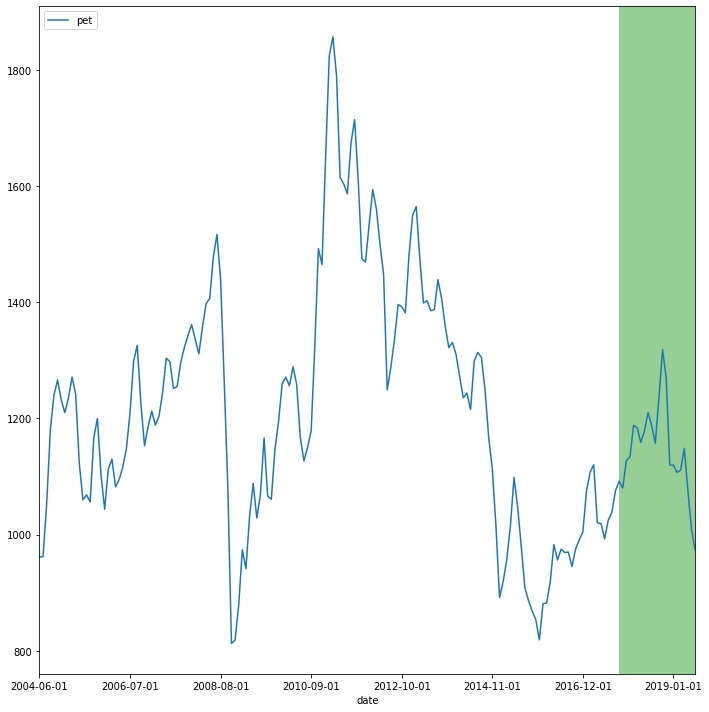

In [475]:
plt.rcParams["figure.figsize"] = (10,10)

pd.merge(train_target, answer_LR,  how='outer').plot('date', 'pet')

# Rotate and align xtick labels
#ax.get_figure().autofmt_xdate()

# make room for tick labels
plt.tight_layout()
plt.axvspan(160, 186, facecolor='#2ca02c', alpha=0.5)

plt.show()

In [476]:
answer_SGD = pd.DataFrame()
rubber_price_SGD = [pred_list_SGD[i][0] for i in range(0, len(pred_list_SGD))]
answer_SGD = test_target[['date']]
answer_SGD['pet']=rubber_price_SGD
answer_SGD.round({'pet': 0}).to_csv('predictedPETPriceSGD.csv', sep=',', header=True, index=False)

!cat predictedPETPriceSGD.csv
#!more predictedPETPriceSGD.csv

date,pet
2016-01-01,801.0
2016-02-01,827.0
2016-03-01,860.0
2016-04-01,899.0
2016-05-01,900.0
2016-06-01,878.0
2016-07-01,878.0
2016-08-01,897.0
2016-09-01,891.0
2016-10-01,905.0
2016-11-01,911.0
2016-12-01,948.0
2017-01-01,1013.0
2017-02-01,1026.0
2017-03-01,1008.0
2017-04-01,939.0
2017-05-01,910.0
2017-06-01,901.0
2017-07-01,931.0
2017-08-01,957.0
2017-09-01,964.0
2017-10-01,993.0
2017-11-01,974.0
2017-12-01,1015.0
2018-01-01,1041.0
2018-02-01,1100.0
2018-03-01,1123.0
2018-04-01,1096.0
2018-05-01,1127.0
2018-06-01,1094.0
2018-07-01,1043.0
2018-08-01,1058.0
2018-09-01,1175.0
2018-10-01,1237.0
2018-11-01,1204.0
2018-12-01,1075.0
2019-01-01,1043.0
2019-02-01,1000.0
2019-03-01,1036.0
2019-04-01,1050.0
2019-05-01,1002.0
2019-06-01,918.0
2019-07-01,897.0


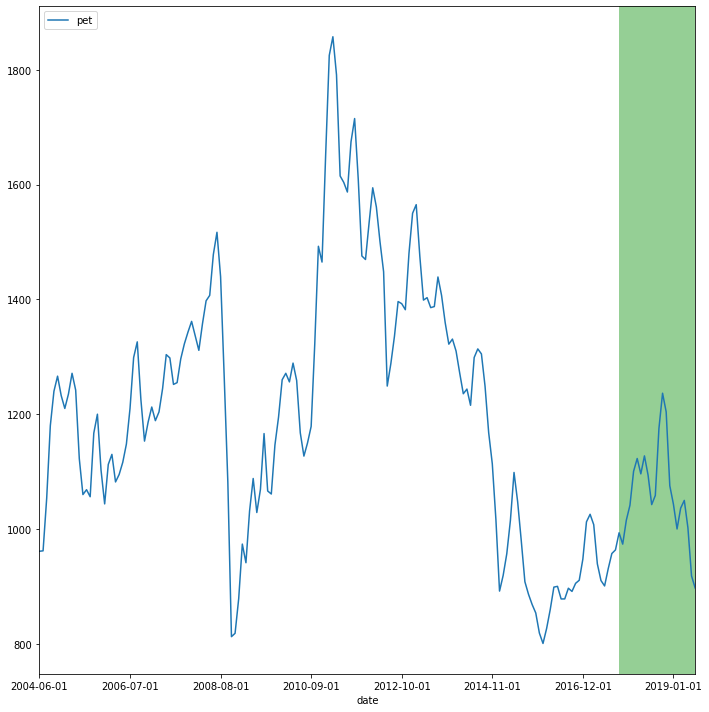

In [477]:
plt.rcParams["figure.figsize"] = (10,10)

pd.merge(train_target, answer_SGD,  how='outer').plot('date', 'pet')

# Rotate and align xtick labels
#ax.get_figure().autofmt_xdate()

# make room for tick labels
plt.tight_layout()
plt.axvspan(160, 184, facecolor='#2ca02c', alpha=0.5)

plt.show()


In [478]:
answer_GB = pd.DataFrame()
rubber_price_GB = [pred_list_GB[i][0] for i in range(0, len(pred_list_GB))]
answer_GB = test_target[['date']]
answer_GB['pet']=rubber_price_GB
answer_GB.round({'pet': 0}).to_csv('predictedPETPriceGB.csv', sep=',', header=True, index=False)

!cat predictedPETPriceGB.csv
#!more predictedPETPriceGB.csv

date,pet
2016-01-01,946.0
2016-02-01,912.0
2016-03-01,949.0
2016-04-01,1055.0
2016-05-01,1062.0
2016-06-01,980.0
2016-07-01,990.0
2016-08-01,990.0
2016-09-01,971.0
2016-10-01,1072.0
2016-11-01,1070.0
2016-12-01,1072.0
2017-01-01,1100.0
2017-02-01,1216.0
2017-03-01,1146.0
2017-04-01,1072.0
2017-05-01,1072.0
2017-06-01,1081.0
2017-07-01,1079.0
2017-08-01,1110.0
2017-09-01,1122.0
2017-10-01,1155.0
2017-11-01,1158.0
2017-12-01,1174.0
2018-01-01,1173.0
2018-02-01,1229.0
2018-03-01,1239.0
2018-04-01,1225.0
2018-05-01,1210.0
2018-06-01,1302.0
2018-07-01,1231.0
2018-08-01,1243.0
2018-09-01,1326.0
2018-10-01,1354.0
2018-11-01,1317.0
2018-12-01,1103.0
2019-01-01,1125.0
2019-02-01,1052.0
2019-03-01,1086.0
2019-04-01,1157.0
2019-05-01,1035.0
2019-06-01,991.0
2019-07-01,991.0


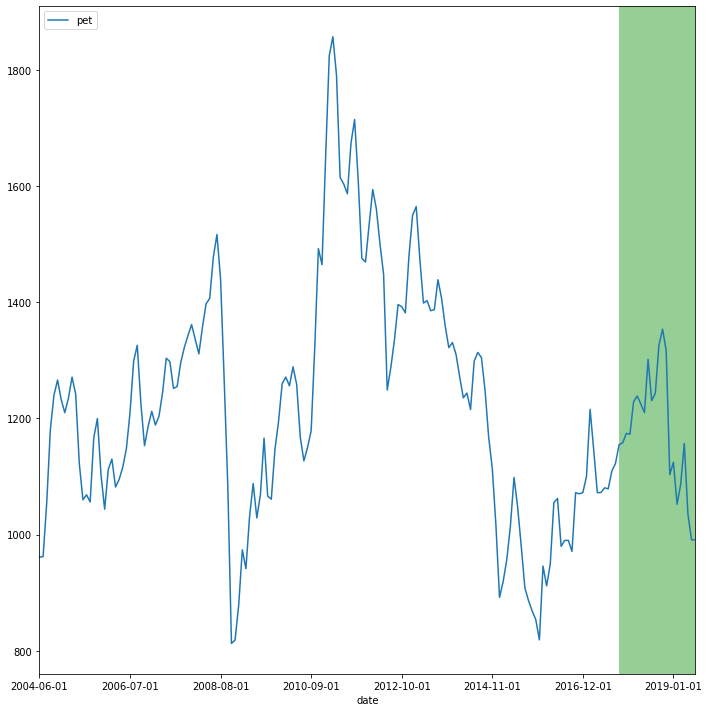

In [479]:
plt.rcParams["figure.figsize"] = (10,10)

pd.merge(train_target, answer_GB,  how='outer').plot('date', 'pet')

# Rotate and align xtick labels
#ax.get_figure().autofmt_xdate()

# make room for tick labels
plt.tight_layout()
plt.axvspan(160, 184, facecolor='#2ca02c', alpha=0.5)

plt.show()
